In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import os
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import PowerTransformer, StandardScaler, label_binarize
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, StackingClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, roc_auc_score, RocCurveDisplay
from imblearn.over_sampling import SMOTE

pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 40)

In [2]:
df = pd.read_csv('credit_modeling_dataset.csv', low_memory=False)

In [3]:
df.head()

,Interest_Rate,Delay_from_due_date,Outstanding_Debt,Num_Credit_Inquiries,Credit_History_Age,Num_Bank_Accounts,Num_Credit_Card,Num_of_Delayed_Payment,Num_of_Loan,Changed_Credit_Limit,Monthly_Balance,Annual_Income,Credit_Mix,Payment_of_Min_Amount,Payment_Behaviour,Type_of_Loan,Credit_Score
0,3.0,3.0,809.98,4.0,265,3.0,4.0,7.0,4.0,11.27,312.494089,19114.12,Good,No,High_spent_Small_value_payments,"['Auto Loan', 'Credit-Builder Loan', 'Personal...",2
1,3.0,-1.0,809.98,4.0,266,3.0,4.0,7.0,4.0,11.27,284.629162,19114.12,Good,No,Low_spent_Large_value_payments,"['Auto Loan', 'Credit-Builder Loan', 'Personal...",2
2,3.0,3.0,809.98,4.0,267,3.0,4.0,7.0,4.0,11.27,331.209863,19114.12,Good,No,Low_spent_Medium_value_payments,"['Auto Loan', 'Credit-Builder Loan', 'Personal...",2
3,3.0,5.0,809.98,4.0,268,3.0,4.0,4.0,4.0,6.27,223.451310,19114.12,Good,No,Low_spent_Small_value_payments,"['Auto Loan', 'Credit-Builder Loan', 'Personal...",2
4,3.0,6.0,809.98,4.0,269,3.0,4.0,4.0,4.0,11.27,341.489231,19114.12,Good,No,High_spent_Medium_value_payments,"['Auto Loan', 'Credit-Builder Loan', 'Personal...",2


In [4]:
df.shape

(94123, 17)

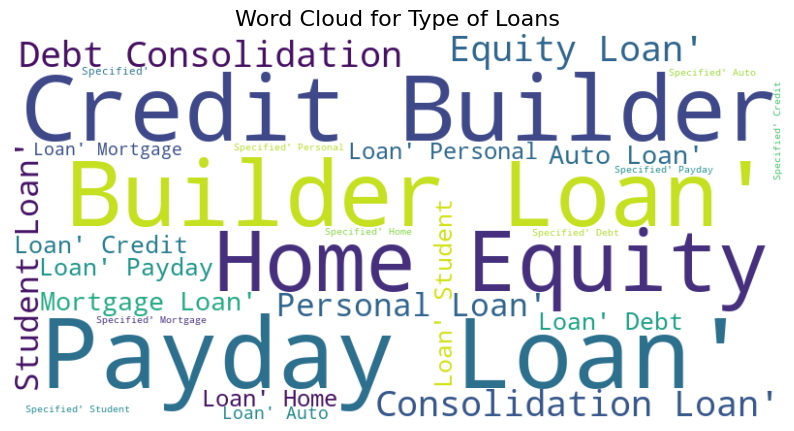

In [5]:
# Generating Word Cloud for Type_of_Loan

# Combine all loan types into a single string
loan_text = " ".join(df['Type_of_Loan'].dropna().values)

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(loan_text)

# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Type of Loans', fontsize=16)
plt.savefig("Type_of_Loan_Word_Cloud.png", dpi=300)
plt.show()
plt.close()

In [6]:
### Feature Engineering of Categorical columns

# Step 1: Encode `Credit_Mix` (Ordinal Encoding)
credit_mix_mapping = {'Good': 3, 'Standard': 2, 'Bad': 1}
df['Credit_Mix'] = df['Credit_Mix'].map(credit_mix_mapping)

# Step 2: Encode `Payment_of_Min_Amount` (Binary Encoding)
payment_min_mapping = {'Yes': 1, 'No': 0}
df['Payment_of_Min_Amount'] = df['Payment_of_Min_Amount'].map(payment_min_mapping)

# Step 3: Encode `Payment_Behaviour` (Ordinal Encoding)
payment_mapping = {
    'High_spent_Large_value_payments': 6,
    'High_spent_Medium_value_payments': 5,
    'High_spent_Small_value_payments': 4,
    'Low_spent_Large_value_payments': 3,
    'Low_spent_Medium_value_payments': 2,
    'Low_spent_Small_value_payments': 1
}
df['Payment_Behaviour'] = df['Payment_Behaviour'].map(payment_mapping)

# Step 4: Process `Type_of_Loan`
# Define unique loan types
unique_loan_types = [
    'Auto Loan', 'Credit-Builder Loan', 'Debt Consolidation Loan', 
    'Home Equity Loan', 'Mortgage Loan', 'No Loan', 
    'Not Specified', 'Payday Loan', 'Personal Loan', 'Student Loan'
]

# Add a new column for each unique loan type
for loan_type in unique_loan_types:
    cleaned_loan_type = loan_type.replace(' ', '_').replace('-', '_').lower()
    df[cleaned_loan_type] = df['Type_of_Loan'].apply(lambda x: x.count(loan_type) if isinstance(x, str) else 0)

# Drop the original `Type_of_Loan` column
df = df.drop(columns=['Type_of_Loan'], errors='ignore')

# Verify the resulting dataset
print("Final Dataset Shape After Encoding:", df.shape)

Final Dataset Shape After Encoding: (94123, 26)


In [7]:
df.head()

,Interest_Rate,Delay_from_due_date,Outstanding_Debt,Num_Credit_Inquiries,Credit_History_Age,Num_Bank_Accounts,Num_Credit_Card,Num_of_Delayed_Payment,Num_of_Loan,Changed_Credit_Limit,Monthly_Balance,Annual_Income,Credit_Mix,Payment_of_Min_Amount,Payment_Behaviour,Credit_Score,auto_loan,credit_builder_loan,debt_consolidation_loan,home_equity_loan,mortgage_loan,no_loan,not_specified,payday_loan,personal_loan,student_loan
0,3.0,3.0,809.98,4.0,265,3.0,4.0,7.0,4.0,11.27,312.494089,19114.12,3,0,4,2,1,1,0,1,0,0,0,0,1,0
1,3.0,-1.0,809.98,4.0,266,3.0,4.0,7.0,4.0,11.27,284.629162,19114.12,3,0,3,2,1,1,0,1,0,0,0,0,1,0
2,3.0,3.0,809.98,4.0,267,3.0,4.0,7.0,4.0,11.27,331.209863,19114.12,3,0,2,2,1,1,0,1,0,0,0,0,1,0
3,3.0,5.0,809.98,4.0,268,3.0,4.0,4.0,4.0,6.27,223.451310,19114.12,3,0,1,2,1,1,0,1,0,0,0,0,1,0
4,3.0,6.0,809.98,4.0,269,3.0,4.0,4.0,4.0,11.27,341.489231,19114.12,3,0,5,2,1,1,0,1,0,0,0,0,1,0


In [8]:
# Modeling the data

# Separate features and target
X = df.drop(columns=['Credit_Score'])  # Assuming 'Credit_Score' is your target
y = df['Credit_Score']

# Split the dataset into training and testing sets (75:25 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# List of skewed numerical features identified earlier
skewed_features = ['Annual_Income', 'Outstanding_Debt', 'Monthly_Balance']

# Initialize PowerTransformer for skewed features
pt = PowerTransformer(method='yeo-johnson')

# Apply PowerTransformer only on the training set, then transform the test set using the same parameters
X_train[skewed_features] = pt.fit_transform(X_train[skewed_features])
X_test[skewed_features] = pt.transform(X_test[skewed_features])

# Initialize StandardScaler for scaling
scaler = StandardScaler()

# Apply scaling to the entire training set, then transform the test set using the same parameters
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert scaled data back to DataFrames for usability
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# Combine scaled features and targets for final training and testing datasets
# train_dataset = X_train_scaled_df.copy()
# train_dataset['Credit_Score'] = y_train.reset_index(drop=True)

# test_dataset = X_test_scaled_df.copy()
# test_dataset['Credit_Score'] = y_test.reset_index(drop=True)

# # Optional: Save train and test datasets for reproducibility
# train_dataset.to_csv('train_dataset.csv', index=False)
# test_dataset.to_csv('test_dataset.csv', index=False)


Evaluating KNN...


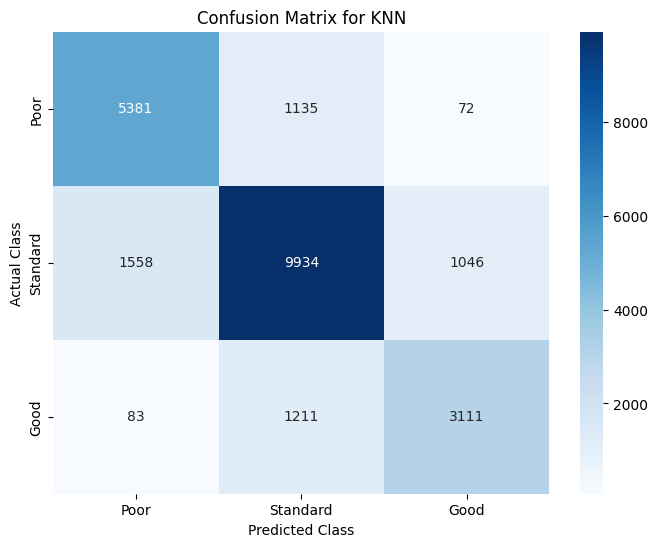

Classification Report for KNN:
              precision    recall  f1-score   support

        Poor       0.77      0.82      0.79      6588
    Standard       0.81      0.79      0.80     12538
        Good       0.74      0.71      0.72      4405

    accuracy                           0.78     23531
   macro avg       0.77      0.77      0.77     23531
weighted avg       0.78      0.78      0.78     23531

Evaluating Logistic Regression...


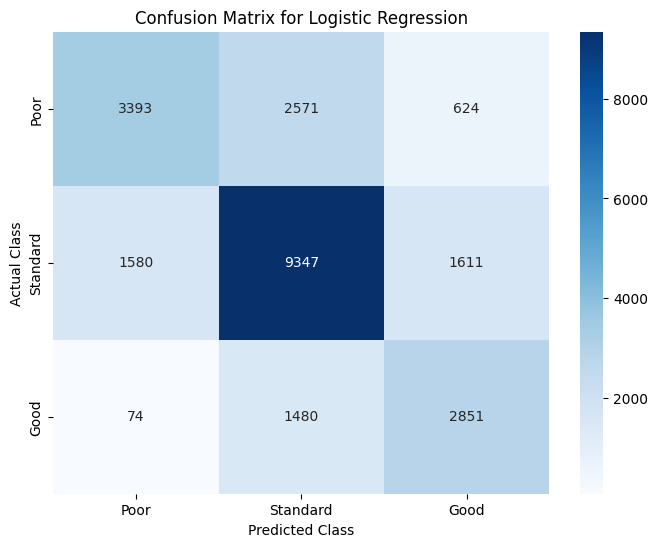

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

        Poor       0.67      0.52      0.58      6588
    Standard       0.70      0.75      0.72     12538
        Good       0.56      0.65      0.60      4405

    accuracy                           0.66     23531
   macro avg       0.64      0.64      0.63     23531
weighted avg       0.66      0.66      0.66     23531

Evaluating Random Forest...


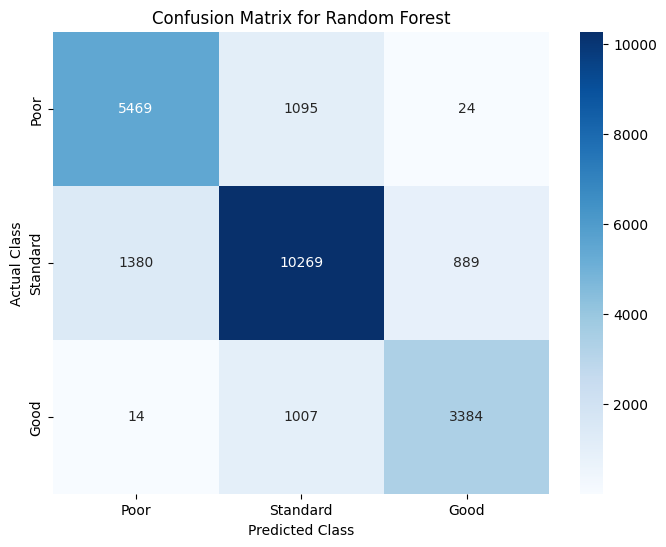

Classification Report for Random Forest:
              precision    recall  f1-score   support

        Poor       0.80      0.83      0.81      6588
    Standard       0.83      0.82      0.82     12538
        Good       0.79      0.77      0.78      4405

    accuracy                           0.81     23531
   macro avg       0.80      0.81      0.81     23531
weighted avg       0.81      0.81      0.81     23531

Evaluating Extra Trees...


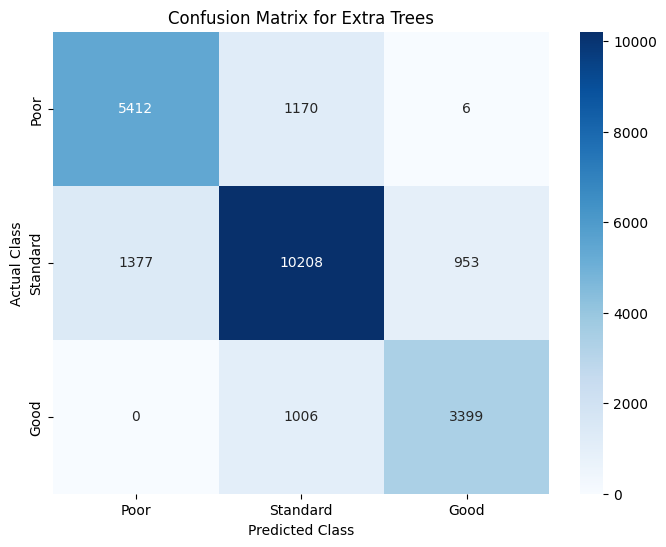

Classification Report for Extra Trees:
              precision    recall  f1-score   support

        Poor       0.80      0.82      0.81      6588
    Standard       0.82      0.81      0.82     12538
        Good       0.78      0.77      0.78      4405

    accuracy                           0.81     23531
   macro avg       0.80      0.80      0.80     23531
weighted avg       0.81      0.81      0.81     23531

Evaluating AdaBoost...


/Users/rahuldev/miniforge3/envs/big_data/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


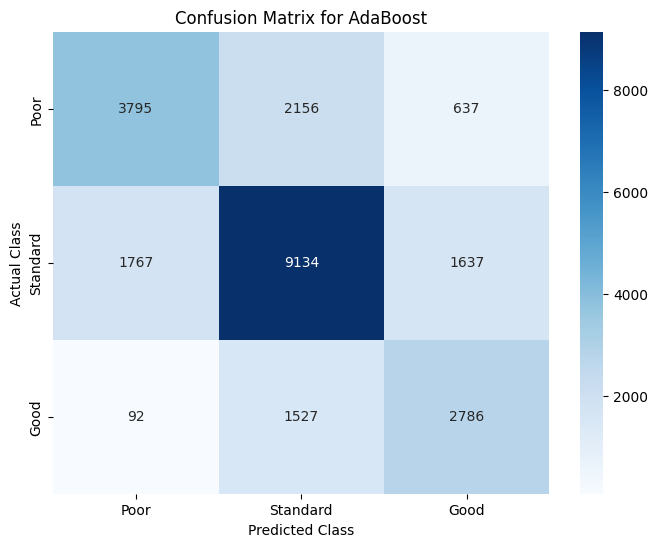

Classification Report for AdaBoost:
              precision    recall  f1-score   support

        Poor       0.67      0.58      0.62      6588
    Standard       0.71      0.73      0.72     12538
        Good       0.55      0.63      0.59      4405

    accuracy                           0.67     23531
   macro avg       0.64      0.65      0.64     23531
weighted avg       0.67      0.67      0.67     23531

Evaluating Gradient Boosting...


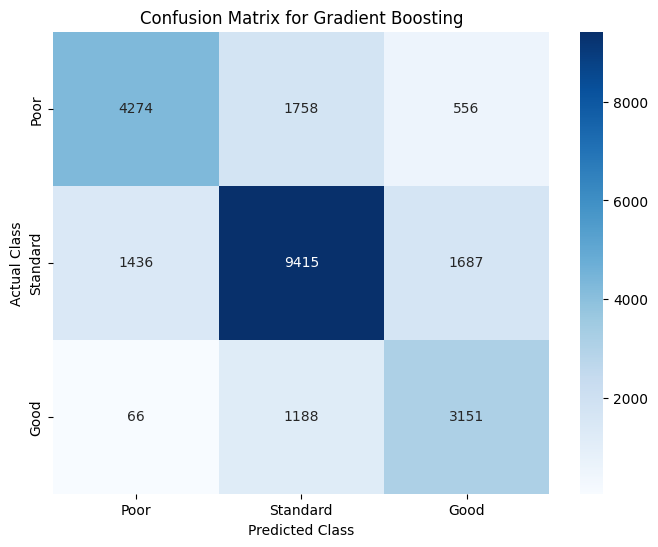

Classification Report for Gradient Boosting:
              precision    recall  f1-score   support

        Poor       0.74      0.65      0.69      6588
    Standard       0.76      0.75      0.76     12538
        Good       0.58      0.72      0.64      4405

    accuracy                           0.72     23531
   macro avg       0.70      0.70      0.70     23531
weighted avg       0.72      0.72      0.72     23531



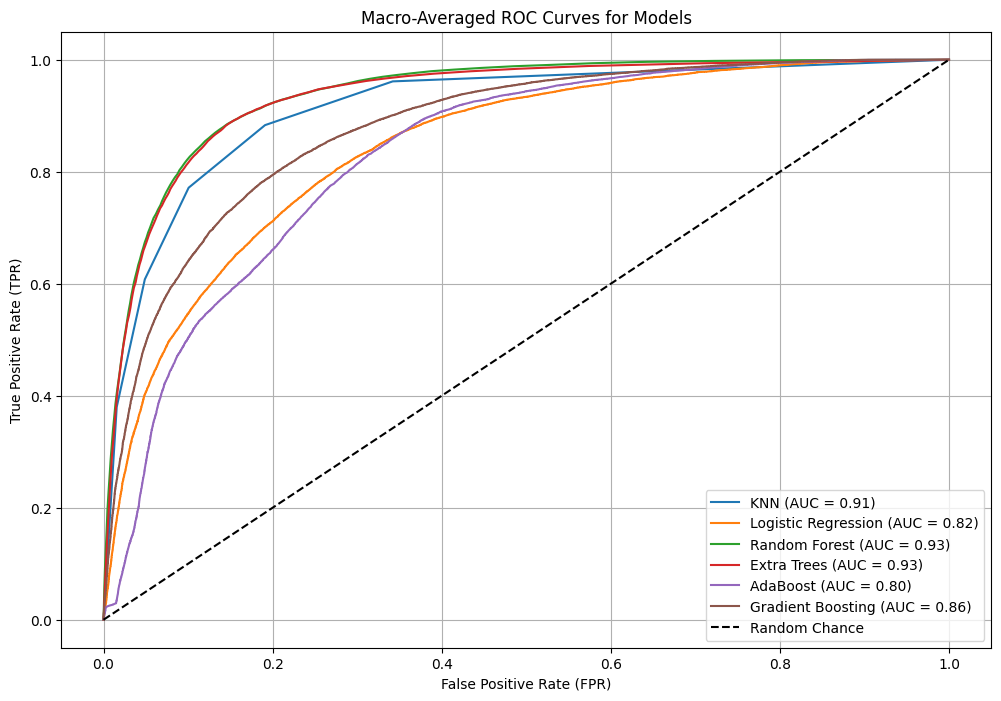

In [9]:

# Define models
models = {
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'Logistic Regression': LogisticRegression(max_iter=500, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'Extra Trees': ExtraTreesClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'AdaBoost': AdaBoostClassifier(n_estimators=50, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42)
}

# Binarize the target (for multi-class ROC AUC)
y_train_bin = label_binarize(y_train, classes=[0, 1, 2])
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
n_classes = y_train_bin.shape[1]

# Classes
classes = ['Poor', 'Standard', 'Good']

# Initialize a dictionary to store results
model_results = {}
roc_data = {}

# Evaluate each model
for model_name, model in models.items():
    print(f"Evaluating {model_name}...")
    model.fit(X_train_scaled_df, y_train)
    y_pred = model.predict(X_test_scaled_df)
    y_prob = model.predict_proba(X_test_scaled_df)

    # Classification report
    report = classification_report(y_test, y_pred, target_names=classes, output_dict=True)
    model_results[model_name] = report

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(f"Confusion Matrix for {model_name}")
    plt.xlabel("Predicted Class")
    plt.ylabel("Actual Class")
    plt.savefig(f"Confusion Matrix for {model_name}.png", dpi=300)
    plt.show()
    plt.close()

    # Macro-Averaged AUC-ROC
    macro_auc = roc_auc_score(y_test_bin, y_prob, average='macro', multi_class='ovr')
    roc_data[model_name] = {"probabilities": y_prob, "macro_auc": macro_auc}

    print(f"Classification Report for {model_name}:")
    print(classification_report(y_test, y_pred, target_names=classes))

# Plot Macro-Averaged ROC Curve
plt.figure(figsize=(12, 8))
for model_name, data in roc_data.items():
    y_prob = data["probabilities"]
    macro_auc = data["macro_auc"]

    # Compute macro-average ROC curve
    fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_prob.ravel())
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {macro_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Macro-Averaged ROC Curves for Models')
plt.legend(loc='lower right')
plt.grid()
plt.savefig("macro_average_roc.png", dpi=300)
plt.show()
plt.close()

In [10]:
# Find the best model based on F1-score and recall for "Poor"
best_model_name = None
best_poor_f1 = 0
best_poor_recall = 0

for model_name, report in model_results.items():
    poor_f1 = report['Poor']['f1-score']
    poor_recall = report['Poor']['recall']
    print(f"{model_name} - F1 (Poor): {poor_f1:.2f}, Recall (Poor): {poor_recall:.2f}")

    if poor_f1 > best_poor_f1:
        best_poor_f1 = poor_f1
        best_poor_recall = poor_recall
        best_model_name = model_name

print(f"\nBest Model for 'Poor': {best_model_name} with F1 = {best_poor_f1:.2f}, Recall = {best_poor_recall:.2f}")


KNN - F1 (Poor): 0.79, Recall (Poor): 0.82
Logistic Regression - F1 (Poor): 0.58, Recall (Poor): 0.52
Random Forest - F1 (Poor): 0.81, Recall (Poor): 0.83
Extra Trees - F1 (Poor): 0.81, Recall (Poor): 0.82
AdaBoost - F1 (Poor): 0.62, Recall (Poor): 0.58
Gradient Boosting - F1 (Poor): 0.69, Recall (Poor): 0.65

Best Model for 'Poor': Random Forest with F1 = 0.81, Recall = 0.83


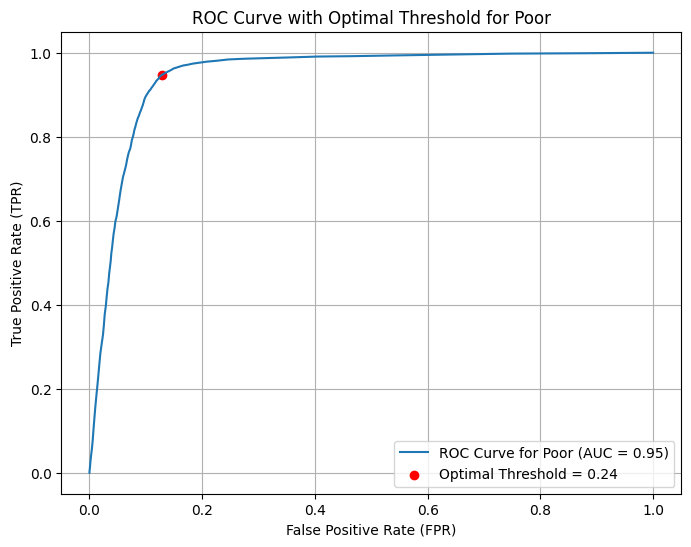

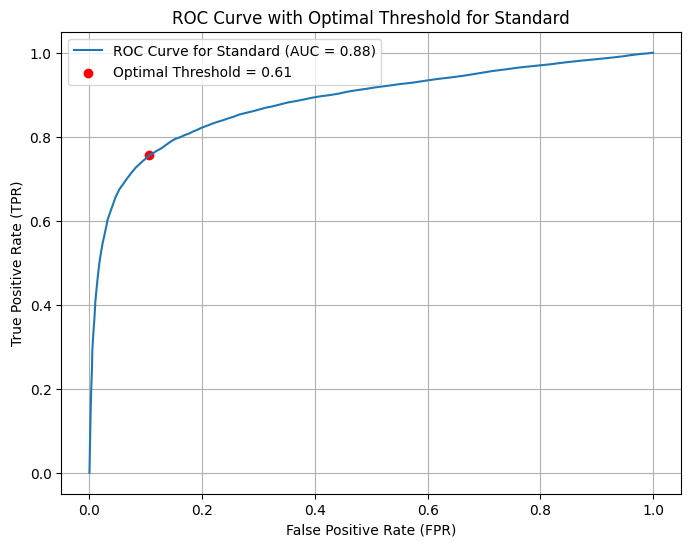

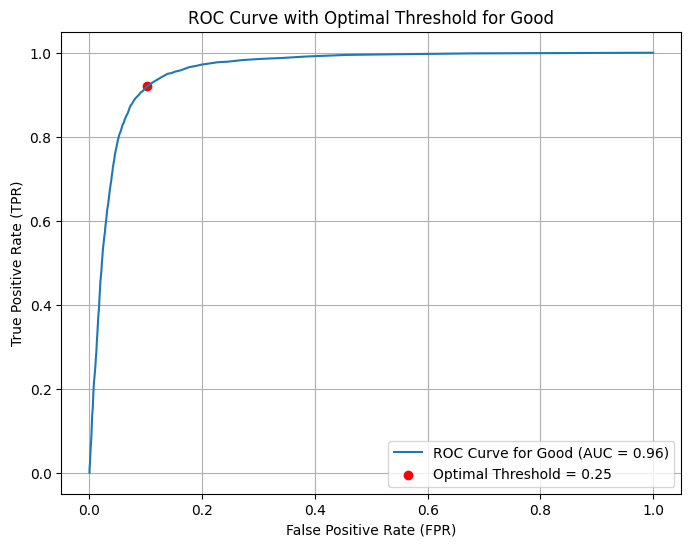

Optimal Thresholds for Each Class: {'Poor': np.float64(0.24), 'Standard': np.float64(0.61), 'Good': np.float64(0.25)}
Debugging Metrics for 'Poor': TP=6237, FN=351, FP=2168, TN=14775
Recall (Poor): 0.9467, Precision (Poor): 0.7421, F1-Score (Poor): 0.8320
Classification Report (After Threshold Tuning):
              precision    recall  f1-score   support

        Poor       0.74      0.95      0.83      6588
    Standard       0.91      0.73      0.81     12538
        Good       0.74      0.86      0.79      4405

    accuracy                           0.81     23531
   macro avg       0.80      0.84      0.81     23531
weighted avg       0.83      0.81      0.81     23531

Confusion Matrix:
[[6237  322   29]
 [2111 9119 1308]
 [  57  568 3780]]
Manually Calculated Recall for 'Poor': 0.9467
Manually Calculated Precision for 'Poor': 0.7421


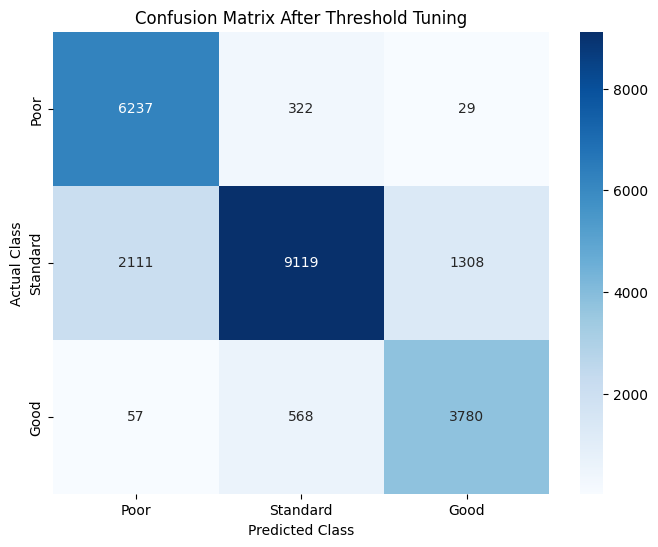

In [11]:
# Fit the best model and predict probabilities
best_model = models[best_model_name]
best_model.fit(X_train_scaled_df, y_train)

# Predict probabilities with the best model
y_prob = best_model.predict_proba(X_test_scaled_df)

# Tune thresholds for each class
optimal_thresholds = {}
for i, cls in enumerate(classes):
    fpr, tpr, thresholds = roc_curve(y_test_bin[:, i], y_prob[:, i])
    optimal_idx = np.argmax(tpr - fpr)  # Maximize TPR - FPR
    optimal_threshold = thresholds[optimal_idx]
    optimal_thresholds[cls] = optimal_threshold

    # Plot ROC curve with optimal threshold
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC Curve for {cls} (AUC = {roc_auc_score(y_test_bin[:, i], y_prob[:, i]):.2f})')
    plt.scatter(fpr[optimal_idx], tpr[optimal_idx], color='red', label=f'Optimal Threshold = {optimal_threshold:.2f}')
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title(f'ROC Curve with Optimal Threshold for {cls}')
    plt.legend()
    plt.grid()
    plt.savefig(f"ROC Curve - {cls}.png", dpi=300)
    plt.show()
    plt.close()

print("Optimal Thresholds for Each Class:", optimal_thresholds)

# Apply the tuned thresholds to make predictions
y_pred_tuned = []
for i in range(len(X_test_scaled_df)):
    class_probs = y_prob[i]
    assigned_class = None
    for cls_idx, cls in enumerate(classes):
        if class_probs[cls_idx] >= optimal_thresholds[cls]:
            assigned_class = cls_idx
            break
    if assigned_class is None:
        assigned_class = np.argmax(class_probs)  # Default to the highest probability class
    y_pred_tuned.append(assigned_class)

# Debugging Step: Recalculate Confusion Matrix Metrics for "Poor"
tp_poor = sum((np.array(y_pred_tuned) == 0) & (y_test == 0))
fn_poor = sum((np.array(y_pred_tuned) != 0) & (y_test == 0))
fp_poor = sum((np.array(y_pred_tuned) == 0) & (y_test != 0))
tn_poor = sum((np.array(y_pred_tuned) != 0) & (y_test != 0))

recall_poor_debug = tp_poor / (tp_poor + fn_poor)
precision_poor_debug = tp_poor / (tp_poor + fp_poor)
f1_poor_debug = 2 * (precision_poor_debug * recall_poor_debug) / (precision_poor_debug + recall_poor_debug)

print(f"Debugging Metrics for 'Poor': TP={tp_poor}, FN={fn_poor}, FP={fp_poor}, TN={tn_poor}")
print(f"Recall (Poor): {recall_poor_debug:.4f}, Precision (Poor): {precision_poor_debug:.4f}, F1-Score (Poor): {f1_poor_debug:.4f}")

# Confusion Matrix and Classification Report after Threshold Tuning
print("Classification Report (After Threshold Tuning):")
print(classification_report(y_test, y_pred_tuned, target_names=classes))

cm = confusion_matrix(y_test, y_pred_tuned, labels=[0, 1, 2])

# Double-check metrics derived from the confusion matrix
print("Confusion Matrix:")
print(cm)
print(f"Manually Calculated Recall for 'Poor': {cm[0, 0] / (cm[0, 0] + cm[0, 1] + cm[0, 2]):.4f}")
print(f"Manually Calculated Precision for 'Poor': {cm[0, 0] / (cm[0, 0] + cm[1, 0] + cm[2, 0]):.4f}")

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title("Confusion Matrix After Threshold Tuning")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")
plt.savefig("Confusion Matrix After Threshold Tuning.png", dpi=300)
plt.show()
plt.close()


In [12]:
# Define the class names
classes = ['Poor', 'Standard', 'Good']

# Fit Extra Trees model
extra_trees_clf.fit(X_train_scaled_df, y_train)
y_prob_et = extra_trees_clf.predict_proba(X_test_scaled_df)

# Tune thresholds for each class
optimal_thresholds_et = {}
for i, cls in enumerate(classes):
    fpr, tpr, thresholds = roc_curve(y_test_bin[:, i], y_prob_et[:, i])
    optimal_idx = np.argmax(tpr - fpr)  # Maximize TPR - FPR
    optimal_threshold = thresholds[optimal_idx]
    optimal_thresholds_et[cls] = optimal_threshold
    
    # Plot ROC curve with optimal threshold
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC Curve for {cls} (AUC = {roc_auc_score(y_test_bin[:, i], y_prob_et[:, i]):.2f})')
    plt.scatter(fpr[optimal_idx], tpr[optimal_idx], color='red', label=f'Optimal Threshold = {optimal_threshold:.2f}')
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title(f'ROC Curve with Optimal Threshold for {cls}')
    plt.legend()
    plt.grid()
    plt.savefig(f'ROC Curve - {cls} (Extra Trees).png', dpi=300)
    plt.show()
    plt.close()

print("Optimal Thresholds for Each Class (Extra Trees):", optimal_thresholds_et)

# Apply the tuned thresholds to make predictions
y_pred_tuned_et = []
for i in range(len(X_test_scaled_df)):
    class_probs = y_prob_et[i]
    assigned_class = None
    for cls_idx, cls in enumerate(classes):
        if class_probs[cls_idx] >= optimal_thresholds_et[cls]:
            assigned_class = cls_idx
            break
    if assigned_class is None:
        assigned_class = np.argmax(class_probs)  # Default to the highest probability class
    y_pred_tuned_et.append(assigned_class)

# Map predictions to class names
y_pred_tuned_mapped_et = pd.Series(y_pred_tuned_et).map({0: 'Poor', 1: 'Standard', 2: 'Good'})

# Classification Report after threshold tuning
print("Classification Report (After Threshold Tuning - Extra Trees):")
print(classification_report(y_test.map({0: 'Poor', 1: 'Standard', 2: 'Good'}), y_pred_tuned_mapped_et, target_names=classes))

# Confusion Matrix after threshold tuning
cm_et = confusion_matrix(y_test.map({0: 'Poor', 1: 'Standard', 2: 'Good'}), y_pred_tuned_mapped_et, labels=classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_et, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title("Confusion Matrix After Threshold Tuning (Extra Trees)")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")
plt.savefig("Confusion Matrix After Threshold Tuning (Extra Trees).png", dpi=300)
plt.show()
plt.close()


NameError: name 'extra_trees_clf' is not defined

# SMOTE Oversampling

Evaluating KNN...


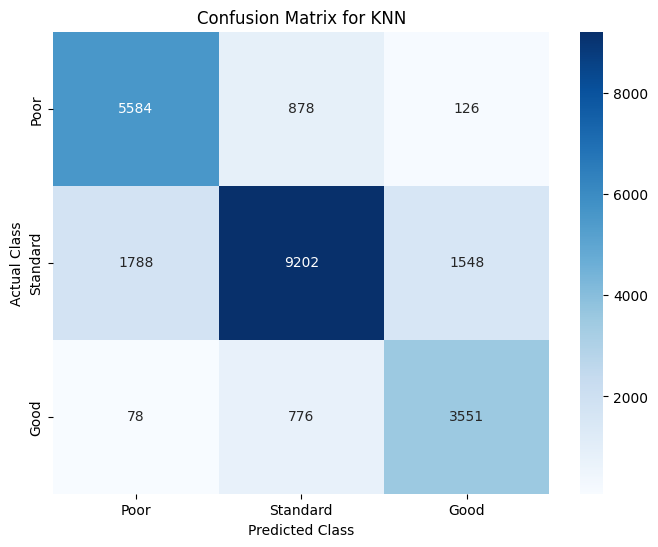

Classification Report for KNN:
              precision    recall  f1-score   support

        Poor       0.75      0.85      0.80      6588
    Standard       0.85      0.73      0.79     12538
        Good       0.68      0.81      0.74      4405

    accuracy                           0.78     23531
   macro avg       0.76      0.80      0.77     23531
weighted avg       0.79      0.78      0.78     23531

Evaluating Logistic Regression...


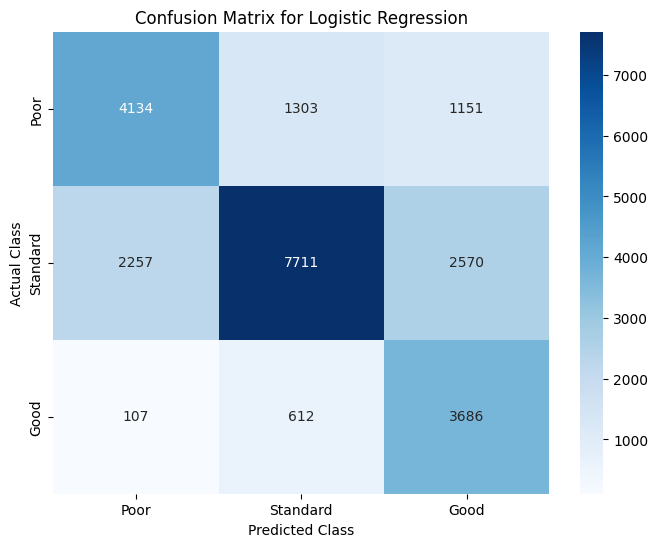

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

        Poor       0.64      0.63      0.63      6588
    Standard       0.80      0.62      0.70     12538
        Good       0.50      0.84      0.62      4405

    accuracy                           0.66     23531
   macro avg       0.64      0.69      0.65     23531
weighted avg       0.70      0.66      0.66     23531

Evaluating Random Forest...


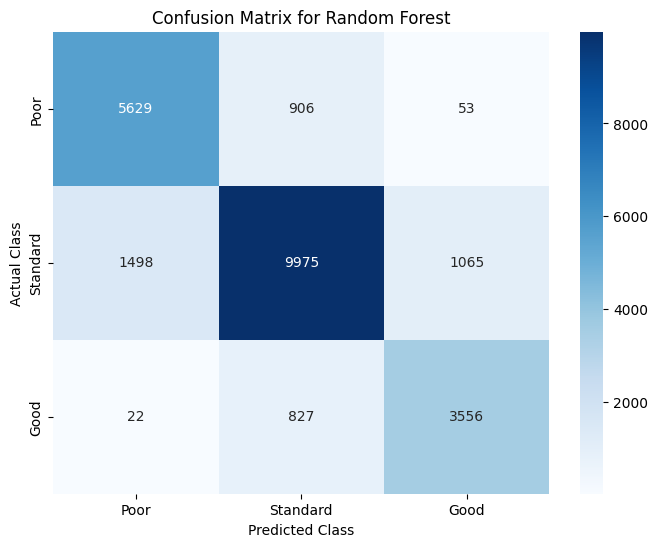

Classification Report for Random Forest:
              precision    recall  f1-score   support

        Poor       0.79      0.85      0.82      6588
    Standard       0.85      0.80      0.82     12538
        Good       0.76      0.81      0.78      4405

    accuracy                           0.81     23531
   macro avg       0.80      0.82      0.81     23531
weighted avg       0.82      0.81      0.81     23531

Evaluating Extra Trees...


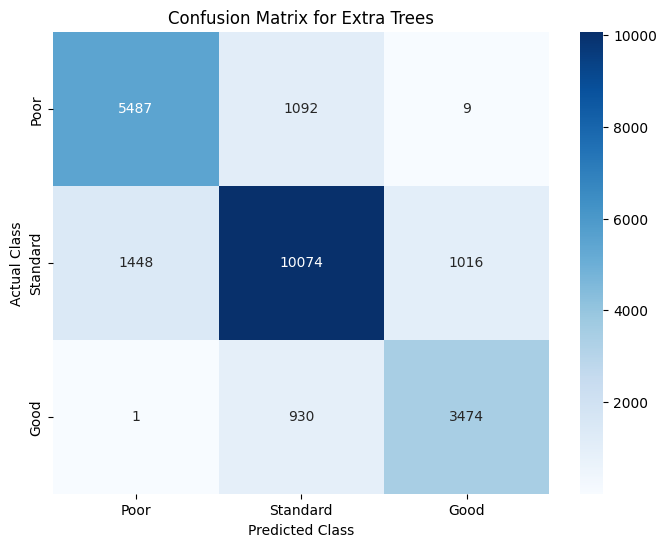

Classification Report for Extra Trees:
              precision    recall  f1-score   support

        Poor       0.79      0.83      0.81      6588
    Standard       0.83      0.80      0.82     12538
        Good       0.77      0.79      0.78      4405

    accuracy                           0.81     23531
   macro avg       0.80      0.81      0.80     23531
weighted avg       0.81      0.81      0.81     23531

Evaluating AdaBoost...


/Users/rahuldev/miniforge3/envs/big_data/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


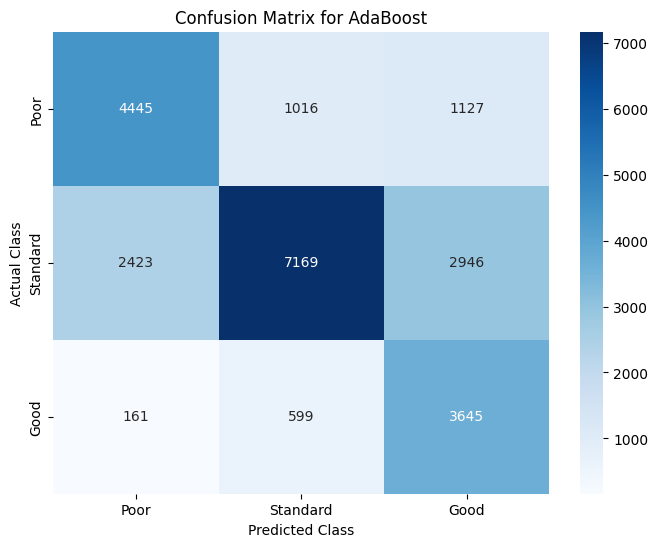

Classification Report for AdaBoost:
              precision    recall  f1-score   support

        Poor       0.63      0.67      0.65      6588
    Standard       0.82      0.57      0.67     12538
        Good       0.47      0.83      0.60      4405

    accuracy                           0.65     23531
   macro avg       0.64      0.69      0.64     23531
weighted avg       0.70      0.65      0.65     23531

Evaluating Gradient Boosting...


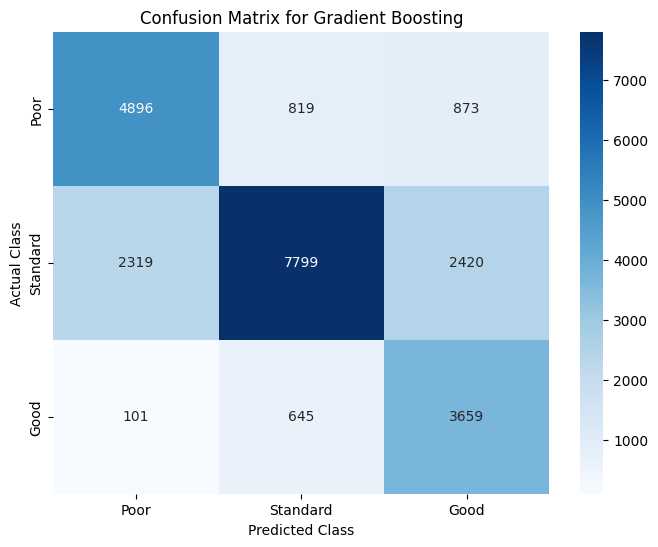

Classification Report for Gradient Boosting:
              precision    recall  f1-score   support

        Poor       0.67      0.74      0.70      6588
    Standard       0.84      0.62      0.72     12538
        Good       0.53      0.83      0.64      4405

    accuracy                           0.69     23531
   macro avg       0.68      0.73      0.69     23531
weighted avg       0.73      0.69      0.70     23531



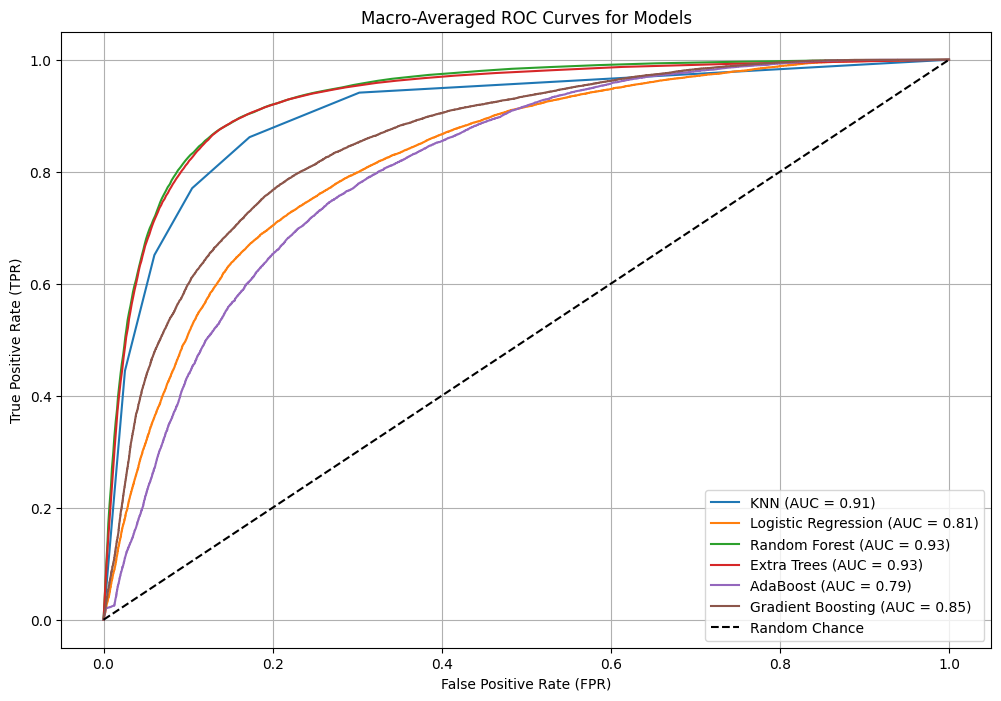

KNN - F1 (Poor): 0.80, Recall (Poor): 0.85
Logistic Regression - F1 (Poor): 0.63, Recall (Poor): 0.63
Random Forest - F1 (Poor): 0.82, Recall (Poor): 0.85
Extra Trees - F1 (Poor): 0.81, Recall (Poor): 0.83
AdaBoost - F1 (Poor): 0.65, Recall (Poor): 0.67
Gradient Boosting - F1 (Poor): 0.70, Recall (Poor): 0.74

Best Model for 'Poor': Random Forest with F1 = 0.82, Recall = 0.85


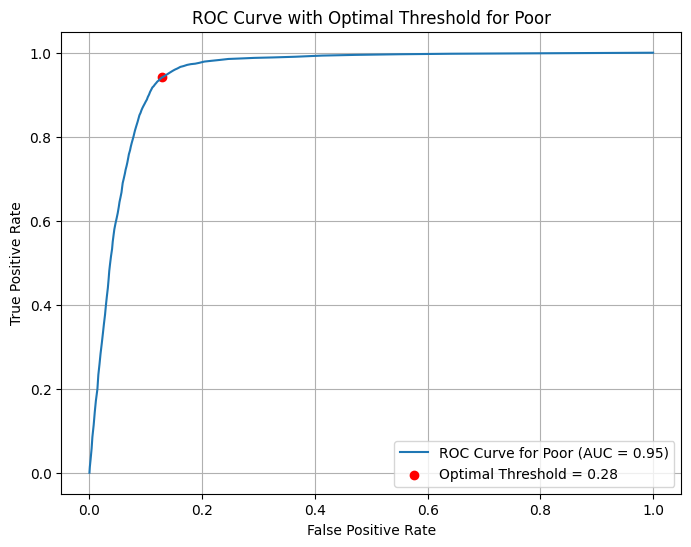

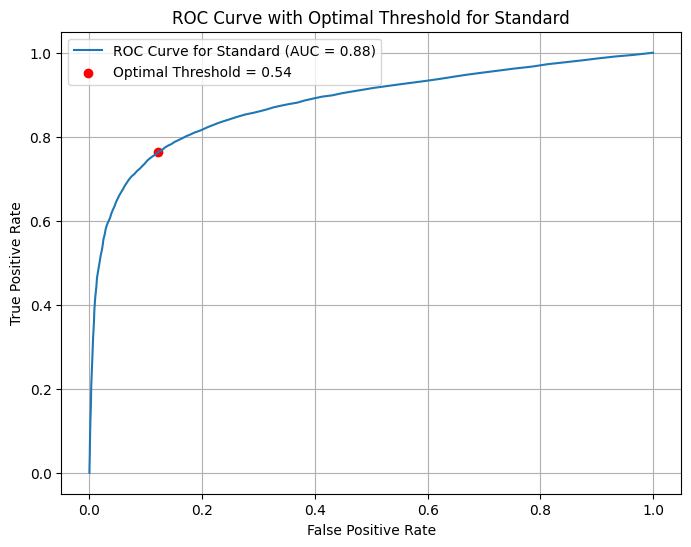

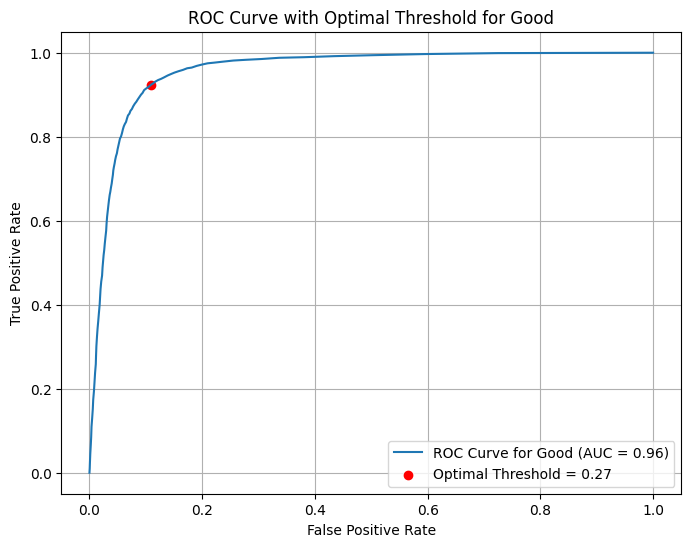

Optimal Thresholds for Each Class: {'Poor': np.float64(0.28), 'Standard': np.float64(0.54), 'Good': np.float64(0.27)}
Classification Report (After Threshold Tuning):
              precision    recall  f1-score   support

        Poor       0.76      0.92      0.83      6588
    Standard       0.91      0.73      0.81     12538
        Good       0.70      0.89      0.78      4405

    accuracy                           0.81     23531
   macro avg       0.79      0.84      0.81     23531
weighted avg       0.83      0.81      0.81     23531



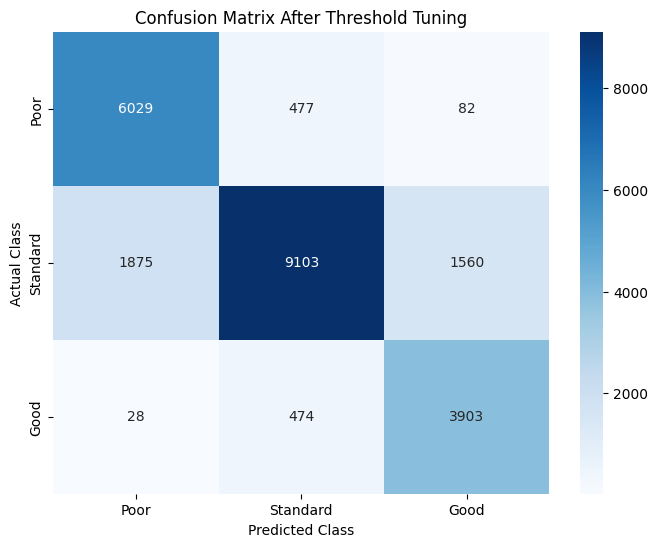

In [13]:
# Define classes
classes = ['Poor', 'Standard', 'Good']

# Step 1: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# Step 2: Apply SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Step 3: Handle Skewness for Numerical Features
skewed_features = ['Annual_Income', 'Outstanding_Debt', 'Monthly_Balance']
pt = PowerTransformer(method='yeo-johnson')
X_train_resampled[skewed_features] = pt.fit_transform(X_train_resampled[skewed_features])
X_test[skewed_features] = pt.transform(X_test[skewed_features])

# Step 4: Standardize Data
scaler = StandardScaler()
X_train_resampled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

# Step 5: Define Models
models = {
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'Logistic Regression': LogisticRegression(max_iter=500, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'Extra Trees': ExtraTreesClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'AdaBoost': AdaBoostClassifier(n_estimators=50, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42)
}

# Step 6: Train and Evaluate Models
model_results = {}
roc_data = {}
y_test_bin = pd.get_dummies(y_test).values  # One-hot encoding for ROC

for model_name, model in models.items():
    print(f"Evaluating {model_name}...")
    model.fit(X_train_resampled, y_train_resampled)
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)

    # Classification report
    report = classification_report(y_test, y_pred, target_names=classes, output_dict=True)
    model_results[model_name] = report

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(f"Confusion Matrix for {model_name}")
    plt.xlabel("Predicted Class")
    plt.ylabel("Actual Class")
    plt.savefig(f"SMOTE Confusion Matrix - {model_name}.png", dpi=300)
    plt.show()
    plt.close()

    # Macro-Averaged AUC-ROC
    macro_auc = roc_auc_score(y_test_bin, y_prob, average='macro', multi_class='ovr')
    roc_data[model_name] = {"probabilities": y_prob, "macro_auc": macro_auc}

    print(f"Classification Report for {model_name}:")
    print(classification_report(y_test, y_pred, target_names=classes))

# Step 7: Plot Macro-Averaged ROC Curves
plt.figure(figsize=(12, 8))
for model_name, data in roc_data.items():
    y_prob = data['probabilities']
    macro_auc = data['macro_auc']
    fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_prob.ravel())
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {macro_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("Macro-Averaged ROC Curves for Models")
plt.legend()
plt.grid()
plt.savefig("SMOTE Macro_Averaged_ROC_Curves.png", dpi=300)
plt.show()
plt.close()

# Step 8: Identify Best Model for "Poor" Class
best_model_name = None
best_poor_f1 = 0
best_poor_recall = 0

for model_name, report in model_results.items():
    poor_f1 = report['Poor']['f1-score']
    poor_recall = report['Poor']['recall']
    print(f"{model_name} - F1 (Poor): {poor_f1:.2f}, Recall (Poor): {poor_recall:.2f}")

    if poor_f1 > best_poor_f1 or (poor_f1 == best_poor_f1 and poor_recall > best_poor_recall):
        best_poor_f1 = poor_f1
        best_poor_recall = poor_recall
        best_model_name = model_name

print(f"\nBest Model for 'Poor': {best_model_name} with F1 = {best_poor_f1:.2f}, Recall = {best_poor_recall:.2f}")

# Step 9: Per-Class Threshold Tuning for Best Model
best_model = models[best_model_name]
y_prob = best_model.predict_proba(X_test_scaled)

optimal_thresholds = {}
for i, cls in enumerate(classes):
    fpr, tpr, thresholds = roc_curve(y_test_bin[:, i], y_prob[:, i])
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    optimal_thresholds[cls] = optimal_threshold

    # Plot ROC curve with optimal threshold
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC Curve for {cls} (AUC = {roc_auc_score(y_test_bin[:, i], y_prob[:, i]):.2f})')
    plt.scatter(fpr[optimal_idx], tpr[optimal_idx], color='red', label=f'Optimal Threshold = {optimal_threshold:.2f}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve with Optimal Threshold for {cls}')
    plt.legend()
    plt.grid()
    plt.savefig(f"SMOTE ROC Curve - {cls} (Best Model).png", dpi=300)
    plt.show()
    plt.close()

print("Optimal Thresholds for Each Class:", optimal_thresholds)

# Step 10: Apply Tuned Thresholds and Evaluate
y_pred_tuned = []
for i in range(len(X_test_scaled)):
    class_probs = y_prob[i]
    adjusted_probs = [class_probs[cls_idx] - optimal_thresholds[cls] for cls_idx, cls in enumerate(classes)]
    assigned_class = np.argmax(adjusted_probs)
    y_pred_tuned.append(assigned_class)

print("Classification Report (After Threshold Tuning):")
print(classification_report(y_test, y_pred_tuned, target_names=classes))

cm = confusion_matrix(y_test, y_pred_tuned, labels=[0, 1, 2])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title("Confusion Matrix After Threshold Tuning")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")
plt.savefig("SMOTE Confusion Matrix After Threshold Tuning.png", dpi=300)
plt.show()
plt.close()
